
Workplace Accident Prediction Project
Author: Fatemeh Radboy
Supervised by: Dr. Jeremy Scerri
Date: May 16, 2025


In [1]:

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk
from nltk.corpus import stopwords
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:

# 1. Data Loading and Exploration
import csv

def load_data(file_path):
    """
    Load the OSHA CSV file with the right settings to handle quotes, commas, and long text.
    """
    try:
        print(f"Loading dataset from: {file_path}")

        df = pd.read_csv(
            file_path,
            encoding='utf-8',           # If this fails, change to 'latin-1'
            engine='python',            # More flexible with text
            quotechar='"',              # Needed for narrative fields
            quoting=csv.QUOTE_MINIMAL,  # Handle quotes correctly
            on_bad_lines='warn',        # Skip broken rows, show warnings
            sep=','                     # Standard CSV
        )

        # Clean column names: remove " symbols
        df.columns = df.columns.str.replace('"', '').str.strip()

        print(f"\n✅ Successfully loaded: {df.shape[0]} rows × {df.shape[1]} columns")
        return df

    except Exception as e:
        print(f"❌ Error loading data: {e}")
        return None


In [3]:
file_path = "/content/January2015toJuly2024.csv"
data = load_data(file_path)


Loading dataset from: /content/January2015toJuly2024.csv

✅ Successfully loaded: 93589 rows × 27 columns


In [4]:
data.shape


(93589, 27)

In [26]:
import pandas as pd
import re
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')  # Ensure this is run once

# 1. Text cleaning helper
def preprocess_text(text):
    """
    Clean and preprocess narrative text
    """
    if not isinstance(text, str):
        return ""

    text = text.lower()  # Lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize whitespace

    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords

    return text

# 2. Main preprocessing function
def preprocess_data(df):
    """
    Preprocess OSHA data:
    - Handle missing values
    - Feature engineering (dates, location, NAICS)
    - Text cleaning
    """
    print("Preprocessing data...")

    data = df.copy()

    # 2.1 Convert EventDate to datetime & extract temporal features
    data['EventDate'] = pd.to_datetime(data['EventDate'], errors='coerce')
    data['Day'] = data['EventDate'].dt.day
    data['Month'] = data['EventDate'].dt.month
    data['Year'] = data['EventDate'].dt.year
    data['Weekday'] = data['EventDate'].dt.dayofweek
    data['IsWeekend'] = data['Weekday'].isin([5, 6]).astype(int)

    # 2.2 Handle missing values
    for col in ['Amputation', 'Primary NAICS', 'Nature', 'Part of Body', 'Event']:
        if col in data.columns:
            if data[col].dtype == 'object':
                data[col] = data[col].fillna('Unknown')
            else:
                data[col] = data[col].fillna(-1)

    # 2.3 Ensure Hospitalized is binary (0 for no hospitalization, 1 for any hospitalization)
    if 'Hospitalized' in data.columns:
        # Convert to numeric first, handling any non-numeric values
        data['Hospitalized'] = pd.to_numeric(data['Hospitalized'], errors='coerce').fillna(0)

        # Convert to binary: 0 = no hospitalizations, 1 = any hospitalizations
        data['Hospitalized'] = (data['Hospitalized'] > 0).astype(int)

        # Verify the conversion
        print(f"Hospitalized value counts after conversion: {data['Hospitalized'].value_counts().to_dict()}")

    # 2.4 Extract NAICS sector (first 2 digits)
    if 'Primary NAICS' in data.columns:
        data['NAICS_Sector'] = data['Primary NAICS'].astype(str).str.extract(r'^(\d{2})').fillna('00')

    # 2.5 Clean Final Narrative
    if 'Final Narrative' in data.columns:
        data['Processed_Narrative'] = data['Final Narrative'].fillna('').apply(preprocess_text)

    # 2.6 Handle Latitude/Longitude & add clustering
    if 'Latitude' in data.columns and 'Longitude' in data.columns:
        data['Latitude'] = pd.to_numeric(data['Latitude'], errors='coerce')
        data['Longitude'] = pd.to_numeric(data['Longitude'], errors='coerce')

        # Cluster valid coordinates
        valid_coords = data.dropna(subset=['Latitude', 'Longitude'])
        if len(valid_coords) > 0:
            coords = valid_coords[['Latitude', 'Longitude']].values
            kmeans = KMeans(n_clusters=min(5, len(coords)), random_state=42).fit(coords)
            data.loc[valid_coords.index, 'Geo_Cluster'] = kmeans.labels_
        else:
            data['Geo_Cluster'] = -1
    else:
        data['Geo_Cluster'] = -1

    print("Preprocessing completed.")
    return data

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
processed_data = preprocess_data(data)


Preprocessing data...
Hospitalized value counts after conversion: {1: 75120, 0: 17891}
Preprocessing completed.


In [28]:
processed_data.head()


,ID,UPA,EventDate,Employer,Address1,Address2,City,State,Zip,Latitude,...,FederalState,Hospitalized_Binary,Day,Month,Year,Weekday,IsWeekend,NAICS_Sector,Processed_Narrative,Geo_Cluster
0,2015010015,931176,2015-01-01,FCI Otisville Federal Correctional Institution,Two Mile Drive,NaN,OTISVILLE,NEW YORK,10963.0,41.46,...,1,1,1,1,2015,3,0,92,three correctional facility guards escorting r...,4.0
1,2015010016,930267,2015-01-01,Kalahari Manufacturing LLC,171 Progress Drive,NaN,LAKE DELTON,WISCONSIN,53940.0,43.59,...,1,1,1,1,2015,3,0,33,employee machine shop received second degree b...,1.0
2,2015010018,929823,2015-01-01,Schneider National Bulk Carrier,420 CORAOPOLIS ROAD,NaN,CORAOPOLIS,PENNSYLVANIA,15108.0,40.49,...,1,1,1,1,2015,3,0,48,truck driver fell approximately feet descendin...,4.0
3,2015010019,929711,2015-01-01,PEPSI BOTTLING GROUP INC.,4541 HOUSTON AVE.,NaN,MACON,GEORGIA,31206.0,32.77,...,1,1,1,1,2015,3,0,42,employees leg pinned truck powered pallet jack...,1.0
4,2015010020,929642,2015-01-01,North American Pipe Corporation,210 South Arch Street,NaN,JANESVILLE,WISCONSIN,53545.0,42.67,...,1,1,1,1,2015,3,0,32,employee working line autobeller reached machi...,1.0


0 means no workers were hospitalized in that incident
1 means one worker was hospitalized
2 means two workers were hospitalized
And so on up to 6, indicating six workers hospitalized in a single incident

In [29]:
processed_data['Hospitalized'].value_counts()


,count
Hospitalized,
1,75120
0,17891


In [30]:
import re
from nltk.corpus import stopwords
import nltk

# Download stopwords if not already downloaded
nltk.download('stopwords', quiet=True)

def preprocess_text(text):
    """
    Clean and preprocess text data
    """
    if not isinstance(text, str):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])

    return text

# Test the function with a sample text
sample_text = "Employee was operating a hydraulic press when their hand got caught, resulting in amputation of 2 fingers. The incident occurred on 02/15/2023 at approximately 3:45 PM."

# Show original text
print("Original text:")
print(sample_text)
print("\n")

# Show processed text
processed = preprocess_text(sample_text)
print("Processed text:")
print(processed)
print("\n")

# Show what was removed (demonstration purposes)
print("Removed content:")
original_words = set(re.sub(r'\s+', ' ', sample_text.lower()).split())
processed_words = set(processed.split())
removed_words = original_words - processed_words
print(", ".join(removed_words))

Original text:
Employee was operating a hydraulic press when their hand got caught, resulting in amputation of 2 fingers. The incident occurred on 02/15/2023 at approximately 3:45 PM.


Processed text:
employee operating hydraulic press hand got caught resulting amputation fingers incident occurred approximately pm


Removed content:
of, fingers., in, on, 2, 02/15/2023, pm., at, was, 3:45, a, caught,, their, the, when


In [31]:
# 3. Feature Engineering and Selection
def engineer_features(data):
    """
    Create and select features for modeling
    """
    print("Engineering features...")

    # 3.1 Define feature sets
    categorical_features = []
    for col in ['State', 'Nature', 'Part of Body', 'Event', 'Source', 'Secondary Source', 'NAICS_Sector', 'Geo_Cluster']:
        if col in data.columns:
            categorical_features.append(col)

    numerical_features = []
    for col in ['Day', 'Month', 'Year', 'Weekday', 'Latitude', 'Longitude']:
        if col in data.columns:
            numerical_features.append(col)

    text_feature = 'Processed_Narrative' if 'Processed_Narrative' in data.columns else None

    # 3.2 Prepare text features using TF-IDF
    if text_feature and data[text_feature].any():
        tfidf = TfidfVectorizer(max_features=100, min_df=5)
        tfidf_matrix = tfidf.fit_transform(data[text_feature])
        tfidf_df = pd.DataFrame(tfidf_matrix.toarray(),
                               columns=[f'tfidf_{i}' for i in range(tfidf_matrix.shape[1])])
        data = pd.concat([data.reset_index(drop=True), tfidf_df], axis=1)

        # Add TF-IDF features to numerical features
        numerical_features.extend([f'tfidf_{i}' for i in range(tfidf_matrix.shape[1])])

        # Show top TF-IDF features for visualization
        print(f"\nTop TF-IDF features:")
        feature_names = tfidf.get_feature_names_out()
        for i in range(min(10, len(feature_names))):
            print(f"tfidf_{i}: {feature_names[i]}")

    # 3.3 Define target variable
    target = 'Hospitalized'

    # 3.4 Create feature and target arrays
    features = categorical_features + numerical_features
    X = data[features].copy()
    y = data[target].copy() if target in data.columns else None

    print(f"\nFeatures selected: {features}")
    print(f"Number of features: {len(features)}")
    print(f"Target variable: {target}")

    # Display feature statistics for numerical features
    if len(numerical_features) > 0:
        print("\nNumerical feature statistics:")
        print(X[numerical_features].describe().T[['count', 'mean', 'min', 'max']])

    # Display feature counts for categorical features
    if len(categorical_features) > 0:
        print("\nCategorical feature value counts (top 3 per feature):")
        for feature in categorical_features:
            print(f"\n{feature}:")
            print(X[feature].value_counts().head(3))

    # Display target distribution
    if y is not None:
        print("\nTarget distribution:")
        print(y.value_counts())
        print(f"Target balance: {y.value_counts(normalize=True).to_dict()}")

    return X, y, categorical_features, numerical_features

# To run and see results:
# X, y, cat_features, num_features = engineer_features(data)

In [32]:
# Assuming 'data' is your preprocessed DataFrame
X, y, cat_features, num_features = engineer_features(data)

# Additional visualization of results:
print("\nFeature matrix shape:", X.shape)
print("Target vector shape:", y.shape if y is not None else None)

# Optional: Show sample rows of the feature matrix
print("\nSample of feature matrix (first 3 rows):")
print(X.head(3))

Engineering features...

Features selected: ['State', 'Nature', 'Part of Body', 'Event', 'Source', 'Secondary Source', 'Latitude', 'Longitude']
Number of features: 8
Target variable: Hospitalized

Numerical feature statistics:
             count       mean     min     max
Latitude   92913.0  36.628193  -34.92   70.34
Longitude  92913.0 -87.562707 -170.71  166.64

Categorical feature value counts (top 3 per feature):

State:
State
TEXAS           15207
FLORIDA         10109
PENNSYLVANIA     7421
Name: count, dtype: int64

Nature:
Nature
111     28394
1311    23446
1972     6512
Name: count, dtype: int64

Part of Body:
Part of Body
4422    10507
4429     8964
4420     6821
Name: count, dtype: int64

Event:
Event
6412    6694
4330    5903
6411    5296
Name: count, dtype: int64

Source:
Source
6629    5031
8621    4104
9999    2751
Name: count, dtype: int64

Secondary Source:
Secondary Source
660.0     4532
6629.0    1987
9273.0    1771
Name: count, dtype: int64

Target distribution:
Hospi

In [33]:
# Necessary imports for model building and evaluation
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, classification_report)
import xgboost as XGBClassifier  # Note: This should normally just be "import xgboost as xgb"

# 4. Model Building and Evaluation
def build_and_evaluate_models(X, y, categorical_features, numerical_features):
    """
    Build and evaluate multiple machine learning models
    """
    print("Building models...")

    # 4.1 Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f"Training set size: {X_train.shape}")
    print(f"Test set size: {X_test.shape}")

    # 4.2 Create preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ]), numerical_features),
            ('cat', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))
            ]), categorical_features)
        ])

    # 4.3 Define models
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'XGBoost': XGBClassifier.XGBClassifier(random_state=42)  # Note: This should normally be xgb.XGBClassifier
    }

    # 4.4 Create, train, and evaluate each model
    results = {}
    feature_importances = {}

    for name, model in models.items():
        print(f"\nTraining {name}...")

        # Create pipeline
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])

        # Train model
        pipeline.fit(X_train, y_train)

        # Predict
        y_pred = pipeline.predict(X_test)
        y_prob = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline, 'predict_proba') else None

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

        # Store results
        results[name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': roc_auc,
            'model': pipeline
        }

        # Extract feature importances
        if name in ['Decision Tree', 'Random Forest', 'XGBoost']:
            # Get the feature names after one-hot encoding
            column_trans = pipeline.named_steps['preprocessor']

            # Get feature names for the categorical features
            cat_pipe = column_trans.transformers_[1][1]
            cat_columns = pipeline.named_steps['preprocessor'].transformers_[1][2]
            if hasattr(cat_pipe['onehot'], 'get_feature_names_out'):
                cat_ohe_feature_names = cat_pipe['onehot'].get_feature_names_out(cat_columns)
            else:
                # For older sklearn versions
                cat_ohe_feature_names = [f"{col}_{val}" for col in cat_columns for val in cat_pipe['onehot'].categories_[cat_columns.index(col)]]

            # Get all feature names
            feature_names = numerical_features + list(cat_ohe_feature_names)

            # Get feature importances
            importances = pipeline.named_steps['classifier'].feature_importances_

            # Store feature importances
            if len(importances) == len(feature_names):
                feature_importances[name] = dict(zip(feature_names, importances))
            else:
                # Handle mismatch in feature names and importances lengths
                print(f"Warning: Feature names and importances have different lengths for {name}")
                feature_importances[name] = dict(zip([f'feature_{i}' for i in range(len(importances))], importances))

        # Print results
        print(f"{name} Results:")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1 Score: {f1:.4f}")
        if roc_auc is not None:
            print(f"  ROC AUC: {roc_auc:.4f}")
        print(f"  Classification Report:\n{classification_report(y_test, y_pred)}")

    return results, feature_importances

In [35]:
# Assuming X, y, cat_features, num_features were created from your previous engineer_features function
results, feature_importances = build_and_evaluate_models(X, y, cat_features, num_features)

# To see a summary of results
print("\nSummary of Model Performance:")
for name, metrics in results.items():
    # Format AUC separately to handle None values
    if metrics['roc_auc'] is not None:
        auc_str = f"{metrics['roc_auc']:.4f}"
    else:
        auc_str = "N/A"

    print(f"{name}: Accuracy={metrics['accuracy']:.4f}, F1={metrics['f1_score']:.4f}, AUC={auc_str}")

# Visualize top features from the best model
if 'Random Forest' in feature_importances:
    print("\nTop 10 Most Important Features (Random Forest):")
    rf_importances = feature_importances['Random Forest']
    sorted_features = sorted(rf_importances.items(), key=lambda x: x[1], reverse=True)

    for feature, importance in sorted_features[:10]:
        print(f"{feature}: {importance:.4f}")

Building models...
Training set size: (74408, 8)
Test set size: (18603, 8)

Training Logistic Regression...
Logistic Regression Results:
  Accuracy: 0.9245
  Precision: 0.9828
  Recall: 0.9223
  F1 Score: 0.9516
  ROC AUC: 0.9648
  Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.93      0.83      3642
           1       0.98      0.92      0.95     14961

    accuracy                           0.92     18603
   macro avg       0.86      0.93      0.89     18603
weighted avg       0.94      0.92      0.93     18603


Training Decision Tree...
Decision Tree Results:
  Accuracy: 0.9064
  Precision: 0.9473
  Recall: 0.9356
  F1 Score: 0.9415
  ROC AUC: 0.8610
  Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.79      0.77      3642
           1       0.95      0.94      0.94     14961

    accuracy                           0.91     18603
   macro avg       0.85      0.8

In [36]:
# Additional imports for grid search
from sklearn.model_selection import GridSearchCV

# 5. Model Optimization with GridSearchCV
def optimize_models(X, y, categorical_features, numerical_features):
    """
    Optimize models using GridSearchCV
    """
    print("\nOptimizing models...")

    # 5.1 Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 5.2 Create preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ]), numerical_features),
            ('cat', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))
            ]), categorical_features)
        ])

    # 5.3 Define parameter grids for each model
    param_grids = {
        'Logistic Regression': {
            'classifier__C': [0.01, 0.1, 1.0, 10.0],
            'classifier__solver': ['liblinear', 'saga']
        },
        'Decision Tree': {
            'classifier__max_depth': [None, 5, 10, 15],
            'classifier__min_samples_split': [2, 5, 10]
        },
        'Random Forest': {
            'classifier__n_estimators': [50, 100],
            'classifier__max_depth': [None, 10, 20],
            'classifier__min_samples_split': [2, 5]
        },
        'XGBoost': {
            'classifier__n_estimators': [50, 100],
            'classifier__max_depth': [3, 5, 7],
            'classifier__learning_rate': [0.01, 0.1]
        }
    }

    # 5.4 Define models
    models = {
        'Logistic Regression': LogisticRegression(random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'XGBoost': XGBClassifier.XGBClassifier(random_state=42)  # Note: This might need adjustment based on your XGBoost import
    }

    # 5.5 Perform grid search for each model
    best_models = {}
    for name, model in models.items():
        print(f"\nOptimizing {name}...")

        # Create pipeline
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])

        # Grid search
        grid_search = GridSearchCV(
            pipeline,
            param_grids[name],
            cv=5,
            scoring='f1',
            n_jobs=-1,
            verbose=1
        )

        # Fit grid search
        grid_search.fit(X_train, y_train)

        # Best model
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_

        # Evaluate on test set
        y_pred = best_model.predict(X_test)
        y_prob = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, 'predict_proba') else None

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

        # Store best model
        best_models[name] = {
            'model': best_model,
            'best_params': best_params,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': roc_auc
        }

        # Print results
        print(f"{name} Best Model Results:")
        print(f"  Best Parameters: {best_params}")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1 Score: {f1:.4f}")
        if roc_auc is not None:
            print(f"  ROC AUC: {roc_auc:.4f}")

    return best_models

In [37]:
# Assuming X, y, cat_features, num_features were created from your previous engineer_features function
best_models = optimize_models(X, y, cat_features, num_features)

# Display a summary comparison of optimized models
print("\nSummary of Optimized Model Performance:")
for name, model_info in best_models.items():
    # Format AUC properly
    if model_info['roc_auc'] is not None:
        auc_str = f"{model_info['roc_auc']:.4f}"
    else:
        auc_str = "N/A"

    print(f"{name}: Accuracy={model_info['accuracy']:.4f}, F1={model_info['f1_score']:.4f}, AUC={auc_str}")

# Find the best performing model based on F1 score
best_model_name = max(best_models.items(), key=lambda x: x[1]['f1_score'])[0]
print(f"\nBest Performing Model: {best_model_name}")
print(f"Best Parameters: {best_models[best_model_name]['best_params']}")


Optimizing models...

Optimizing Logistic Regression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Logistic Regression Best Model Results:
  Best Parameters: {'classifier__C': 0.1, 'classifier__solver': 'liblinear'}
  Accuracy: 0.9242
  Precision: 0.9841
  Recall: 0.9206
  F1 Score: 0.9513
  ROC AUC: 0.9649

Optimizing Decision Tree...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Decision Tree Best Model Results:
  Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 10}
  Accuracy: 0.9226
  Precision: 0.9844
  Recall: 0.9184
  F1 Score: 0.9502
  ROC AUC: 0.9585

Optimizing Random Forest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Random Forest Best Model Results:
  Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
  Accuracy: 0.9236
  Precision: 0.9760
  Recall: 0.9277
  F1 Score: 0.9513
  ROC AUC: 0.9639

Optimizing XGBoost...
Fitting 5 

In [40]:
# Import necessary libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split

# Create train-test split to use for visualizations
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Visualization Functions (as defined previously)
def visualize_feature_importance(feature_importances):
    """
    Visualize feature importances from different models
    """
    print("\nVisualizing feature importances...")

    for model_name, importances in feature_importances.items():
        # Sort importances
        sorted_importances = dict(sorted(importances.items(), key=lambda x: x[1], reverse=True)[:15])

        # Create plot
        plt.figure(figsize=(12, 8))
        plt.barh(list(sorted_importances.keys()), list(sorted_importances.values()))
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.title(f'Top 15 Feature Importances for {model_name}')
        plt.tight_layout()
        plt.savefig(f'feature_importances_{model_name.replace(" ", "_")}.png')
        plt.show()

def visualize_model_comparison(results):
    """
    Visualize model comparison results
    """
    print("\nVisualizing model comparisons...")

    metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
    models = list(results.keys())

    # Create comparison dataframe
    comparison_data = []
    for model in models:
        model_metrics = [model]
        for metric in metrics:
            value = results[model][metric]
            if value is not None:
                model_metrics.append(value)
            else:
                model_metrics.append(0)  # Replace None with 0 for visualization
        comparison_data.append(model_metrics)

    comparison_df = pd.DataFrame(comparison_data, columns=['Model'] + metrics)
    comparison_df.set_index('Model', inplace=True)

    # Create heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(comparison_df, annot=True, cmap='Blues', fmt='.4f')
    plt.title('Model Performance Comparison')
    plt.tight_layout()
    plt.savefig('model_comparison_heatmap.png')
    plt.show()

    # Create bar chart for each metric
    for metric in metrics:
        plt.figure(figsize=(10, 6))
        sns.barplot(x=comparison_df.index, y=comparison_df[metric])
        plt.title(f'Model Comparison - {metric.replace("_", " ").title()}')
        plt.ylabel(metric.replace("_", " ").title())
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(f'model_comparison_{metric}.png')
        plt.show()

def visualize_confusion_matrices(results, X_test, y_test):
    """
    Visualize confusion matrices for each model
    """
    print("\nVisualizing confusion matrices...")

    for name, result in results.items():
        model = result['model']
        y_pred = model.predict(X_test)

        # Calculate confusion matrix
        cm = confusion_matrix(y_test, y_pred)

        # Create plot
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Not Hospitalized', 'Hospitalized'],
                    yticklabels=['Not Hospitalized', 'Hospitalized'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix - {name}')
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_{name.replace(" ", "_")}.png')
        plt.show()

def visualize_roc_curves(results, X_test, y_test):
    """
    Visualize ROC curves for each model
    """
    print("\nVisualizing ROC curves...")

    plt.figure(figsize=(10, 8))

    for name, result in results.items():
        model = result['model']

        # Only if model can predict probabilities
        if hasattr(model, 'predict_proba'):
            y_prob = model.predict_proba(X_test)[:, 1]

            # Calculate ROC curve
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            roc_auc = result['roc_auc']

            # Plot ROC curve
            plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')

    # Plot diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], 'k--')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.tight_layout()
    plt.savefig('roc_curves.png')
    plt.show()

def visualize_data_insights(data):
    """
    Visualize insights from the processed data
    """
    print("\nVisualizing data insights...")

    # 1. Distribution of target variable
    if 'Hospitalized' in data.columns:
        plt.figure(figsize=(8, 6))
        sns.countplot(x='Hospitalized', data=data)
        plt.title('Distribution of Hospitalization')
        plt.xlabel('Hospitalized')
        plt.ylabel('Count')
        plt.savefig('target_distribution.png')
        plt.show()

    # 2. Hospitalization by State (if available)
    if 'State' in data.columns and 'Hospitalized' in data.columns:
        # Get top 10 states
        top_states = data['State'].value_counts().nlargest(10).index
        state_data = data[data['State'].isin(top_states)]

        plt.figure(figsize=(12, 8))
        sns.countplot(y='State', hue='Hospitalized', data=state_data)
        plt.title('Hospitalization by State (Top 10)')
        plt.xlabel('Count')
        plt.ylabel('State')
        plt.tight_layout()
        plt.savefig('hospitalization_by_state.png')
        plt.show()

    # 3. Hospitalization by Event Type
    if 'Event' in data.columns and 'Hospitalized' in data.columns:
        # Get top 10 events
        top_events = data['Event'].value_counts().nlargest(10).index
        event_data = data[data['Event'].isin(top_events)]

        plt.figure(figsize=(12, 8))
        sns.countplot(y='Event', hue='Hospitalized', data=event_data)
        plt.title('Hospitalization by Event Type (Top 10)')
        plt.xlabel('Count')
        plt.ylabel('Event Type')
        plt.tight_layout()
        plt.savefig('hospitalization_by_event.png')
        plt.show()

    # 4. Hospitalization by Body Part
    if 'Part of Body' in data.columns and 'Hospitalized' in data.columns:
        # Get top 10 body parts
        top_body_parts = data['Part of Body'].value_counts().nlargest(10).index
        body_part_data = data[data['Part of Body'].isin(top_body_parts)]

        plt.figure(figsize=(12, 8))
        sns.countplot(y='Part of Body', hue='Hospitalized', data=body_part_data)
        plt.title('Hospitalization by Body Part (Top 10)')
        plt.xlabel('Count')
        plt.ylabel('Body Part')
        plt.tight_layout()
        plt.savefig('hospitalization_by_body_part.png')
        plt.show()

    # 5. Geographic Distribution
    if 'Latitude' in data.columns and 'Longitude' in data.columns:
        # Filter for valid coordinates
        geo_data = data.dropna(subset=['Latitude', 'Longitude'])

        if len(geo_data) > 0:
            plt.figure(figsize=(12, 10))

            # Plot points colored by hospitalization if available
            if 'Hospitalized' in data.columns:
                hospitalized = geo_data[geo_data['Hospitalized'] == 1]
                not_hospitalized = geo_data[geo_data['Hospitalized'] == 0]

                plt.scatter(not_hospitalized['Longitude'], not_hospitalized['Latitude'],
                           alpha=0.5, c='blue', label='Not Hospitalized')
                plt.scatter(hospitalized['Longitude'], hospitalized['Latitude'],
                           alpha=0.5, c='red', label='Hospitalized')
            else:
                plt.scatter(geo_data['Longitude'], geo_data['Latitude'], alpha=0.5)

            plt.title('Geographical Distribution of Accidents')
            plt.xlabel('Longitude')
            plt.ylabel('Latitude')
            if 'Hospitalized' in data.columns:
                plt.legend()
            plt.tight_layout()
            plt.savefig('geographical_distribution.png')
            plt.show()


Visualizing feature importances...


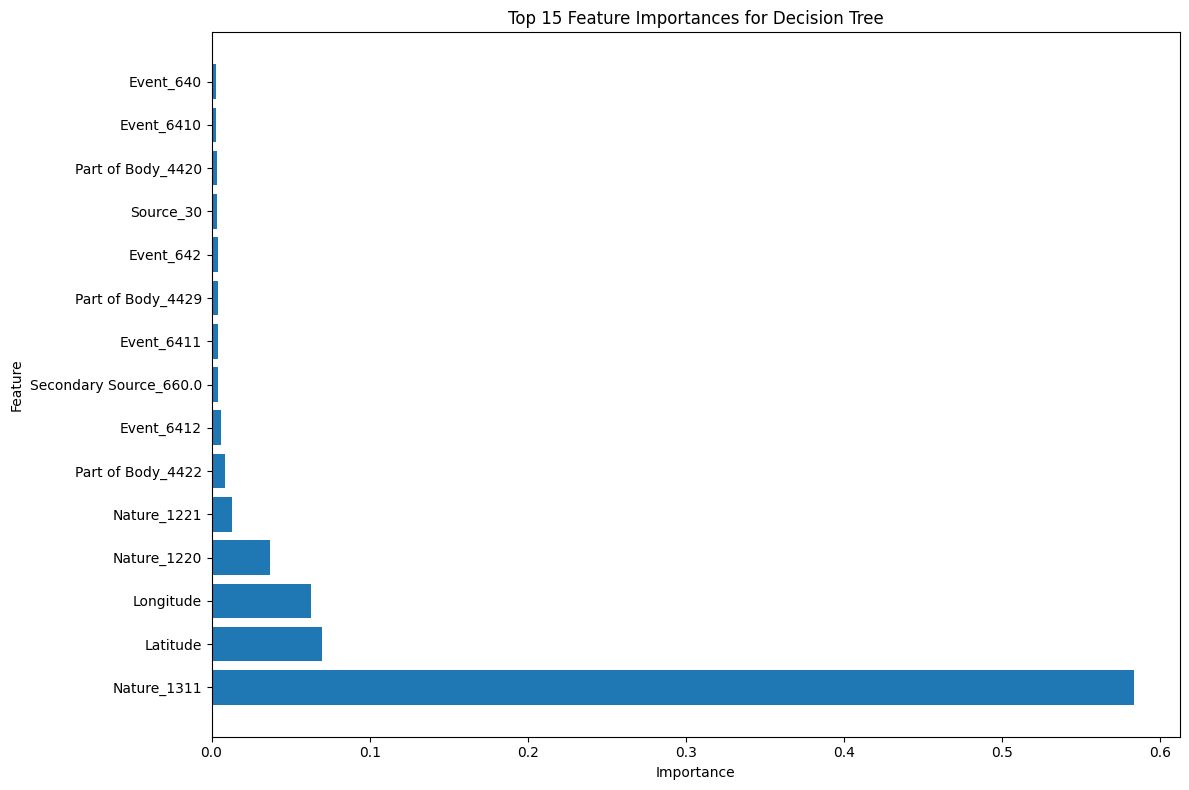

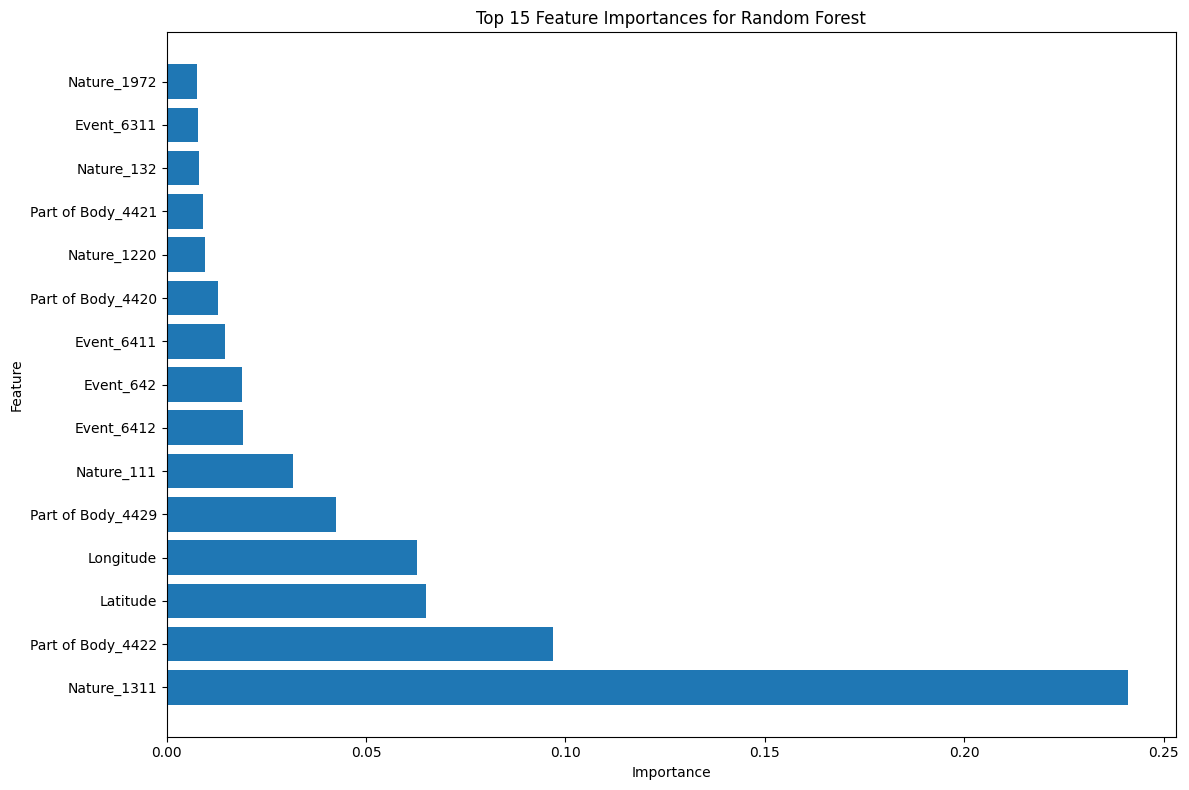

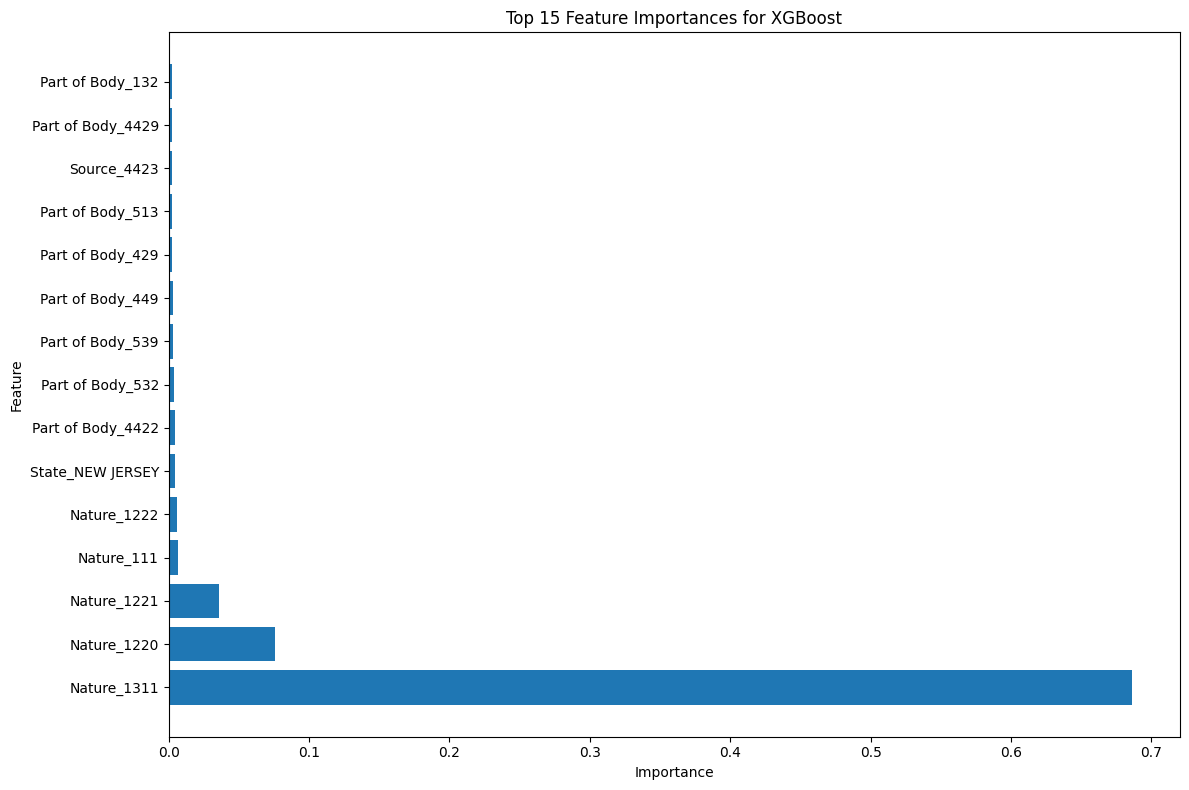


Visualizing data insights...


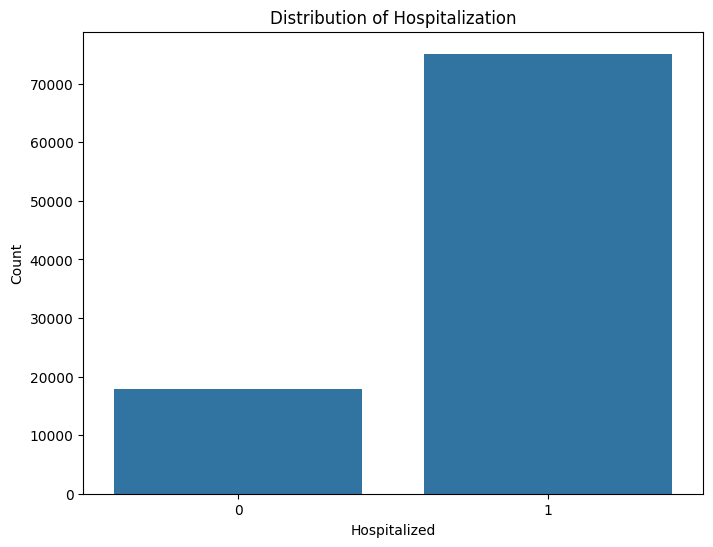

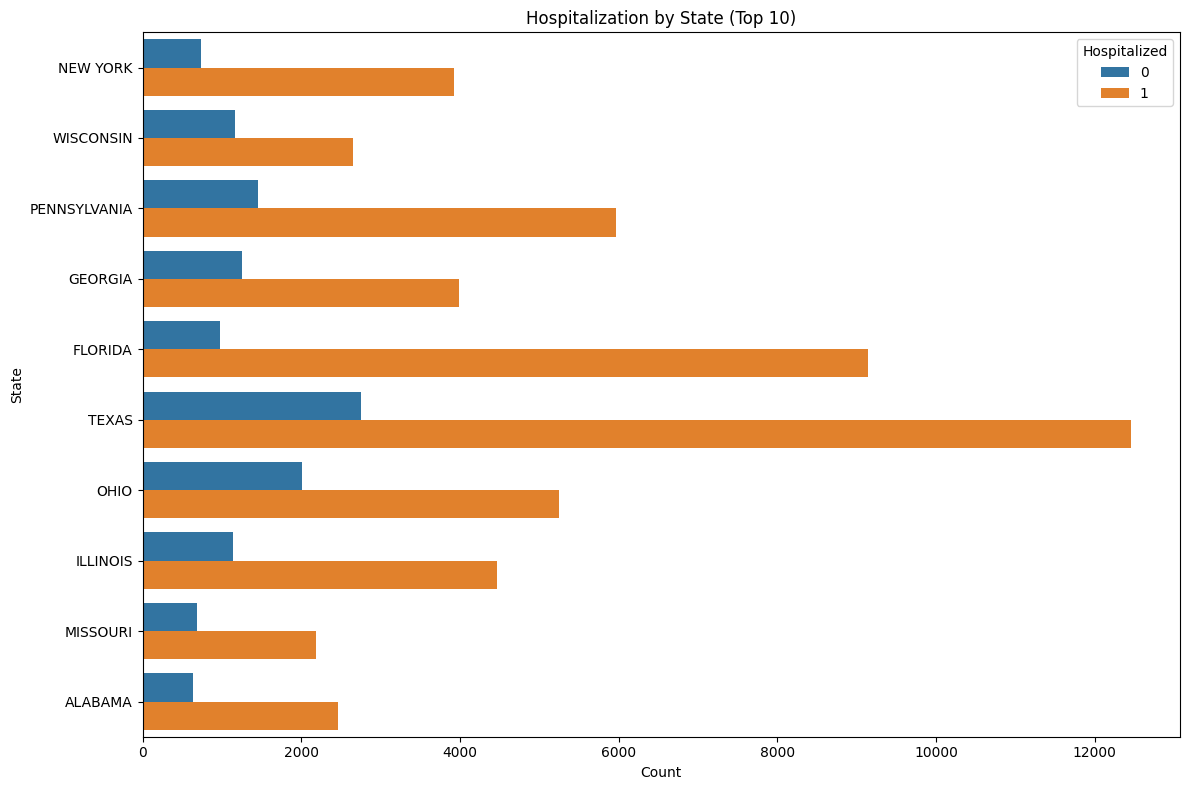

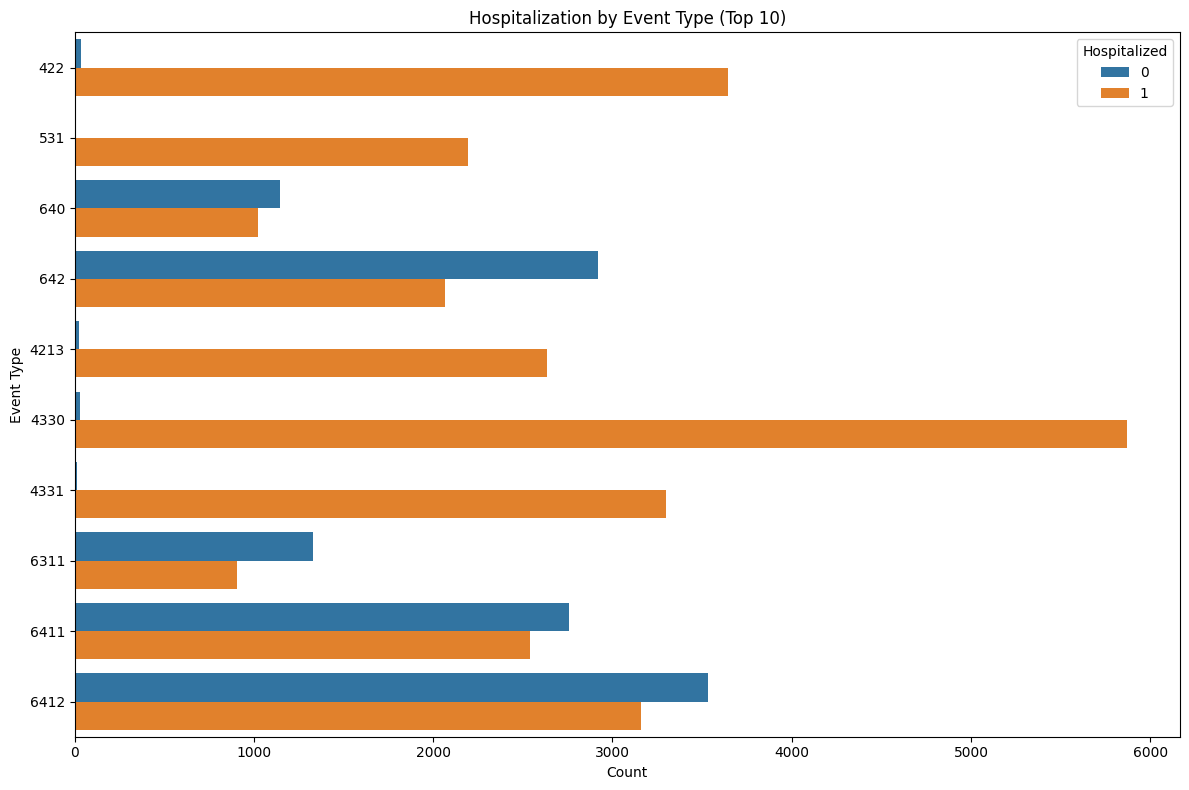

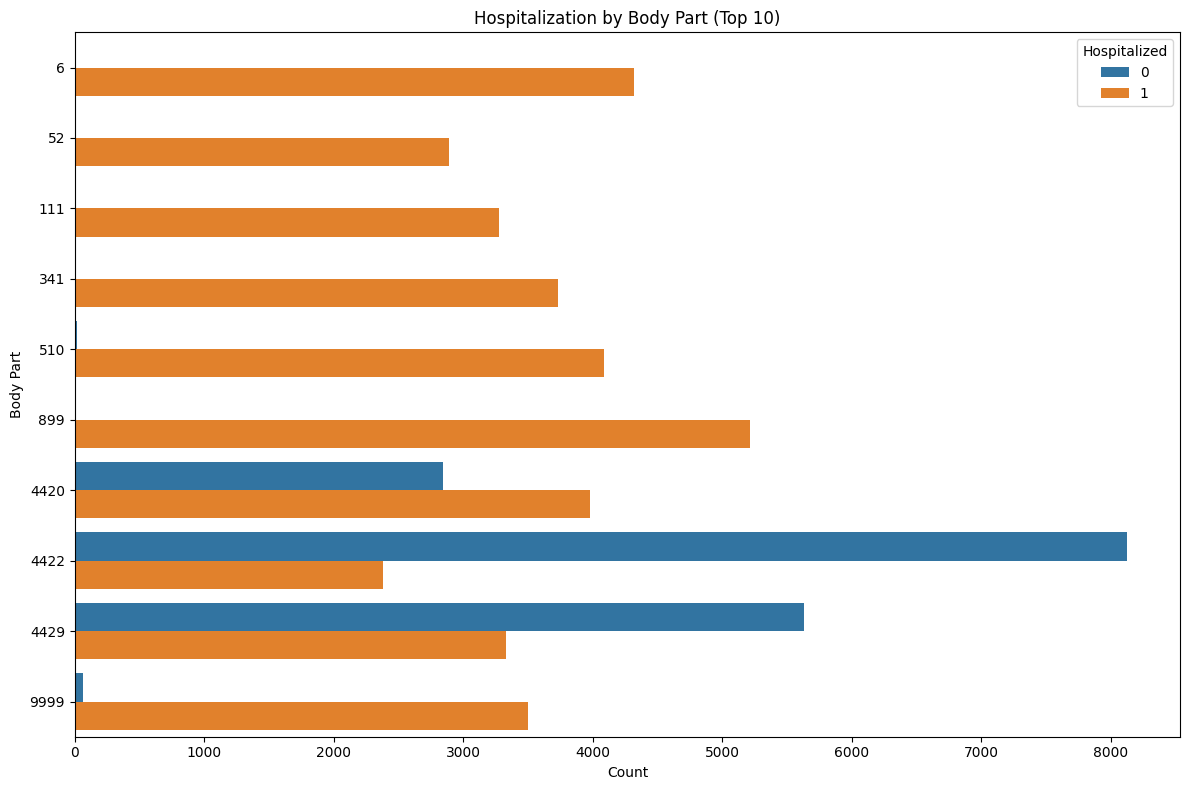

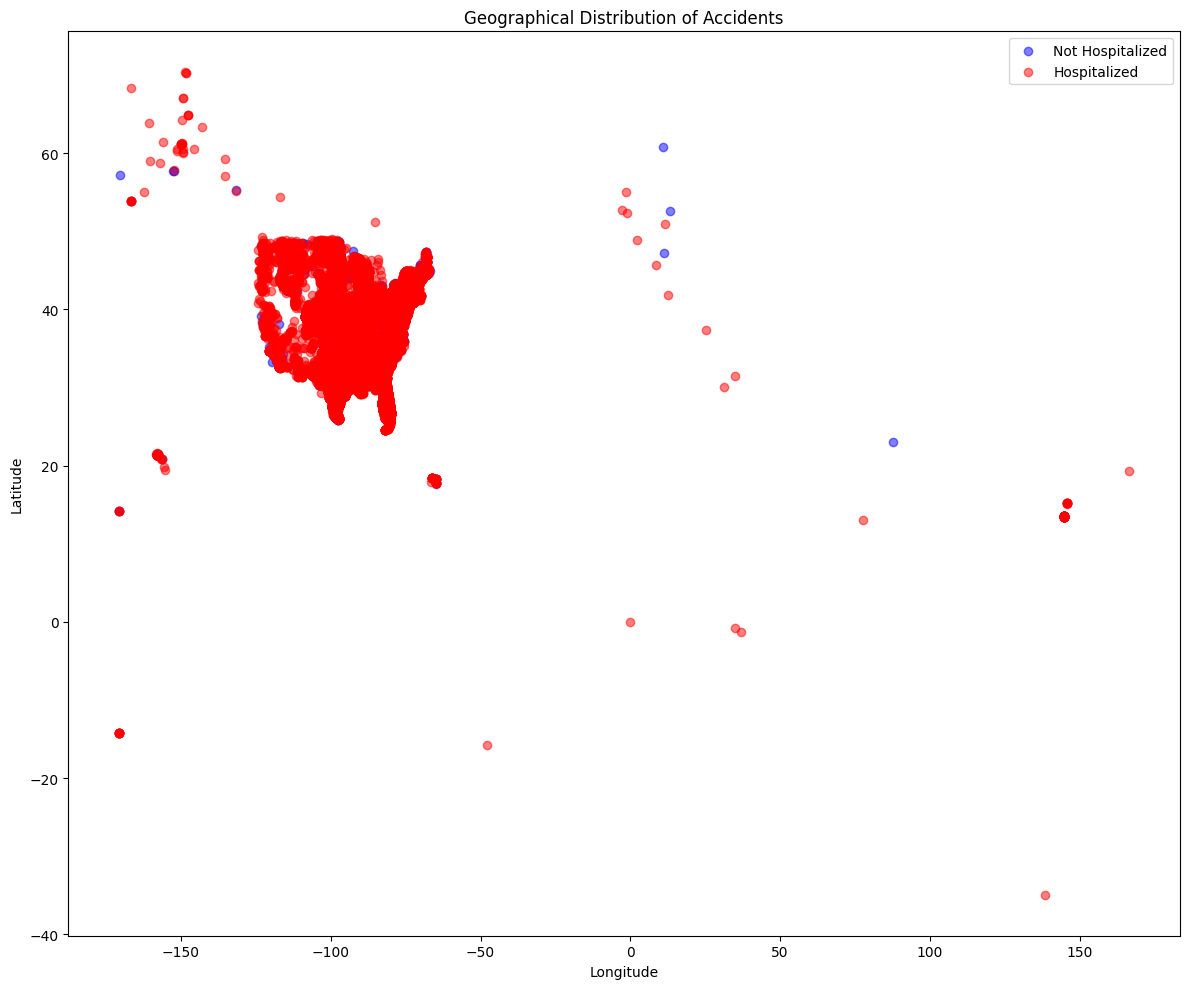


Visualizing model comparisons...


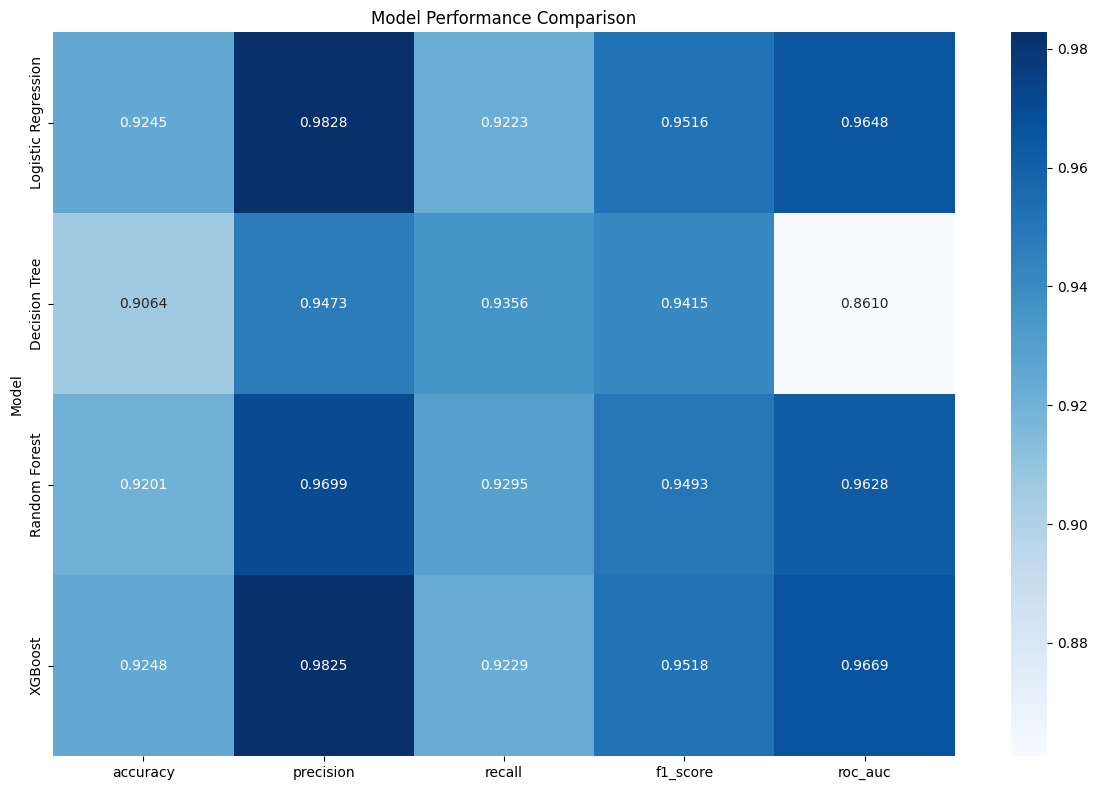

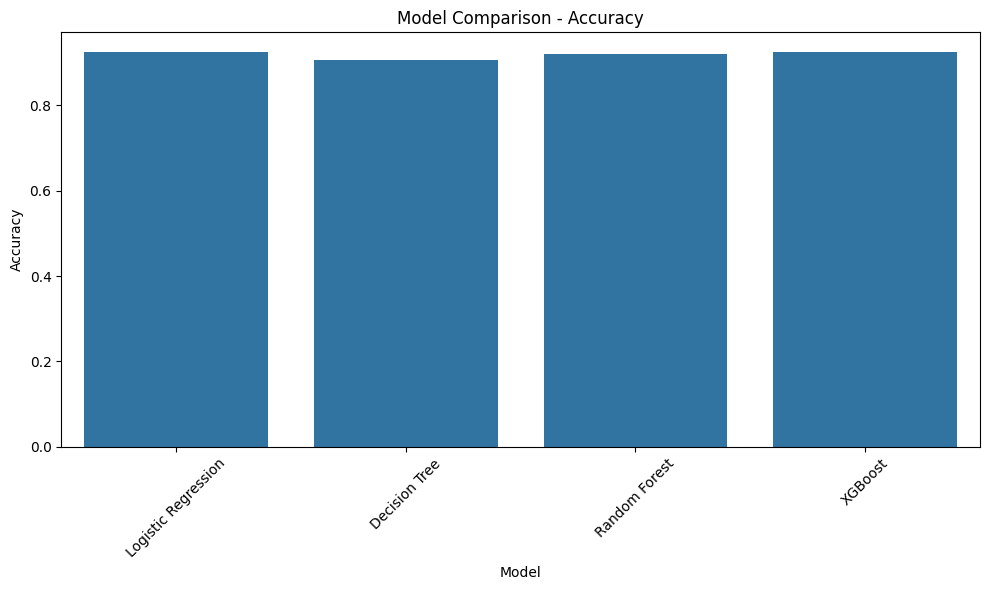

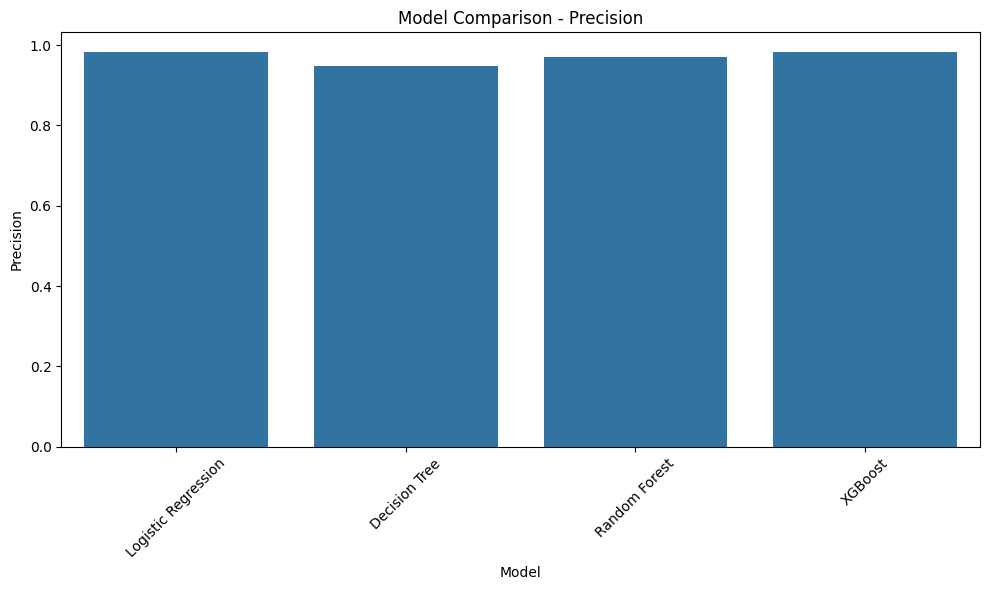

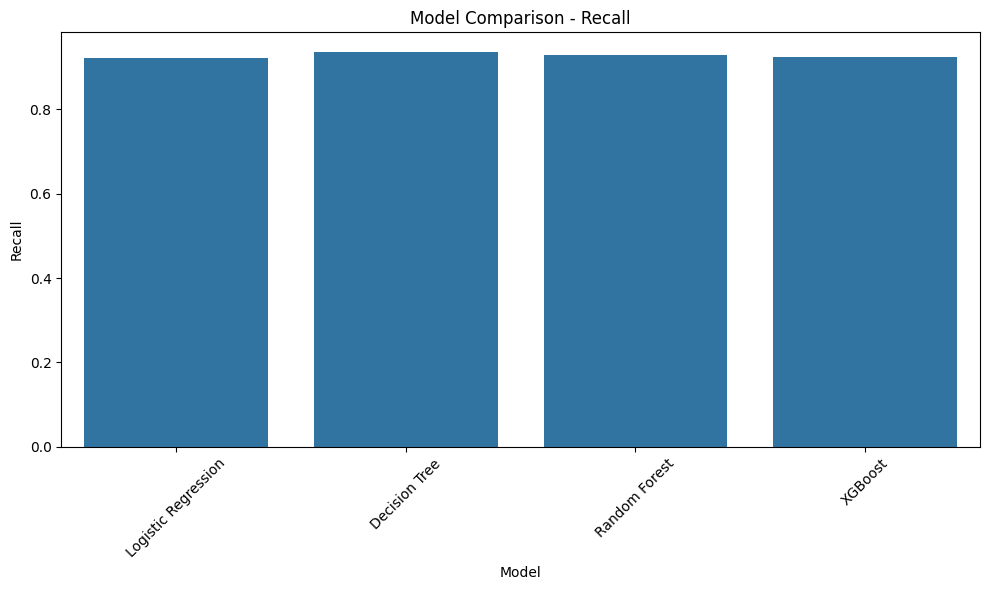

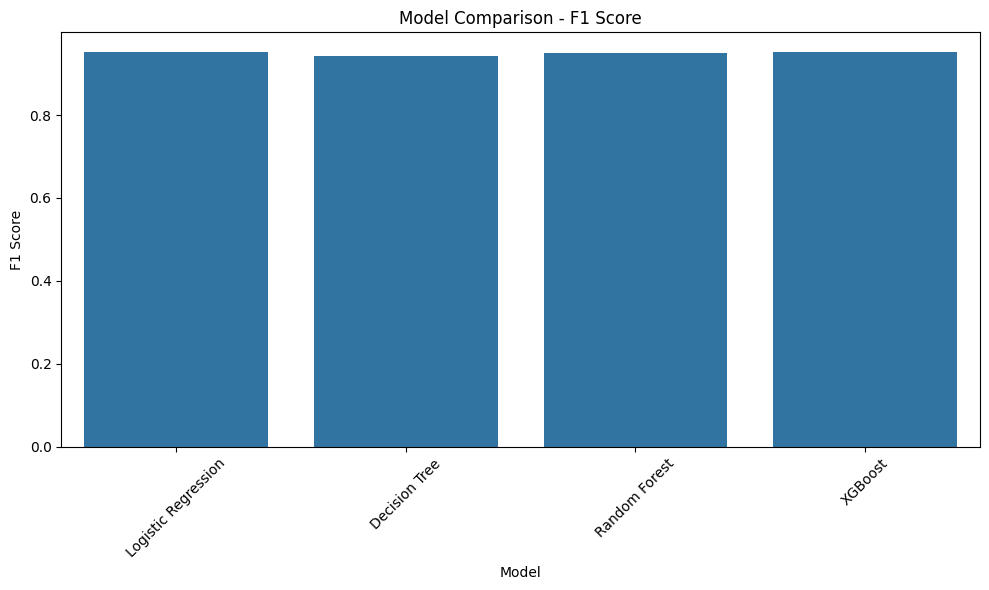

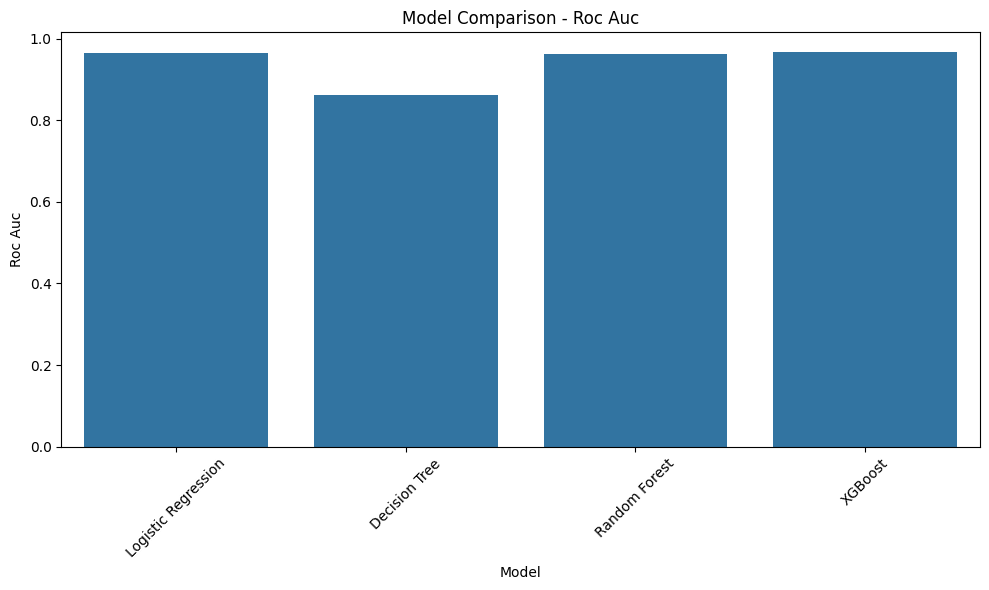


Visualizing model comparisons...


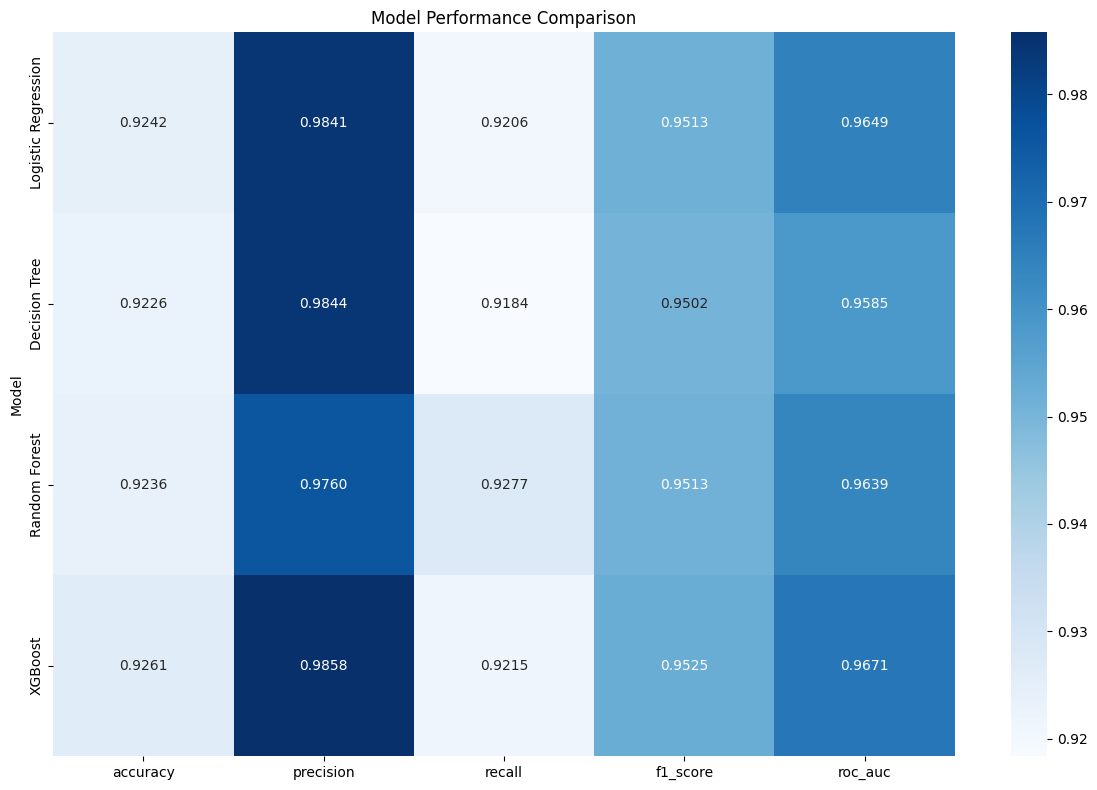

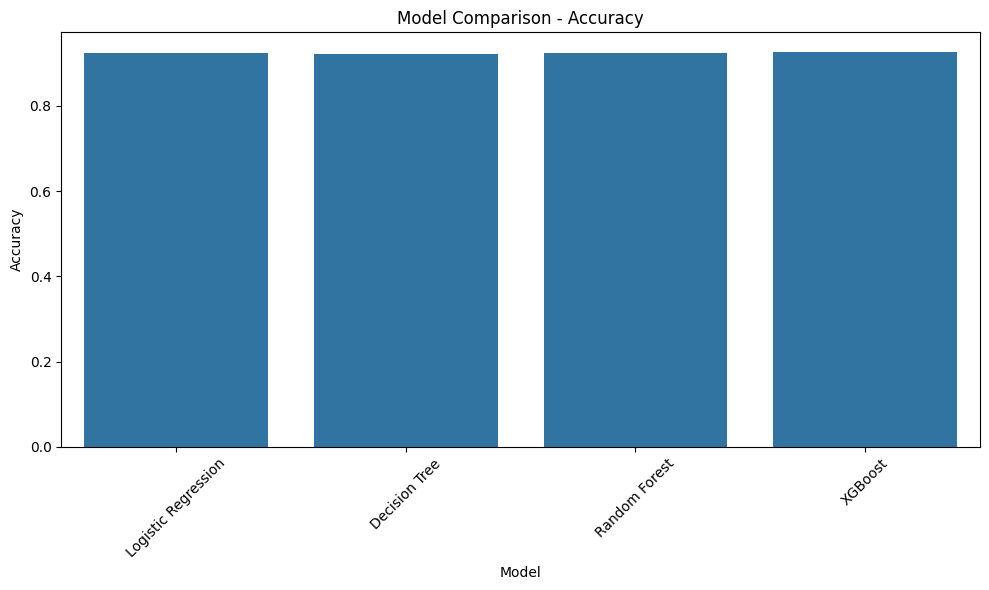

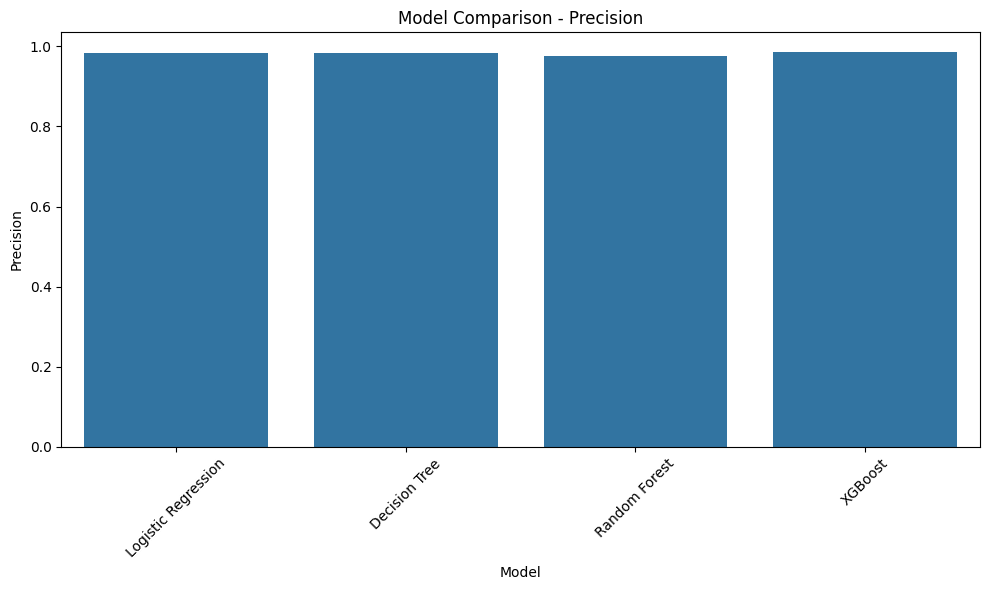

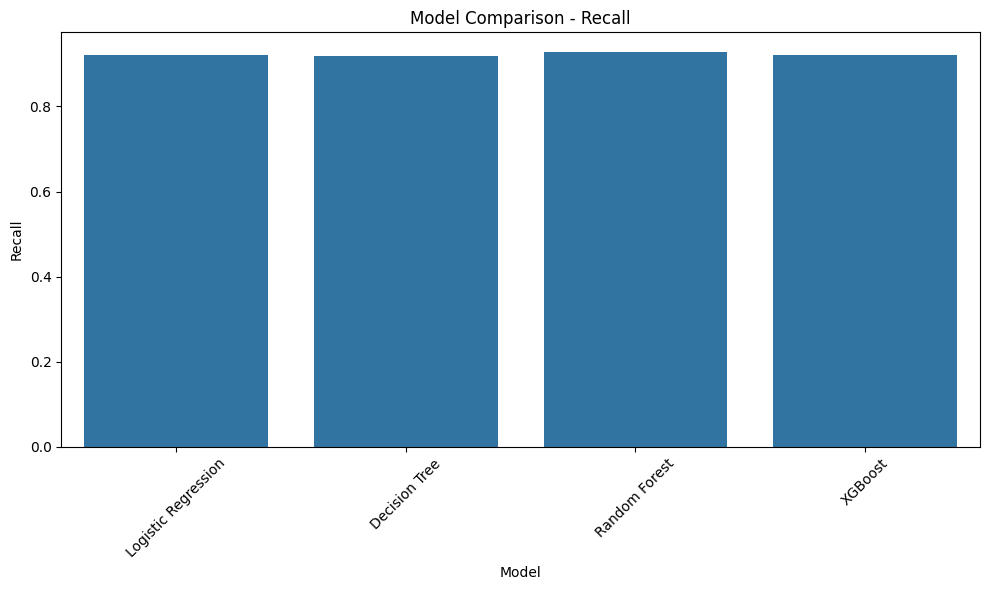

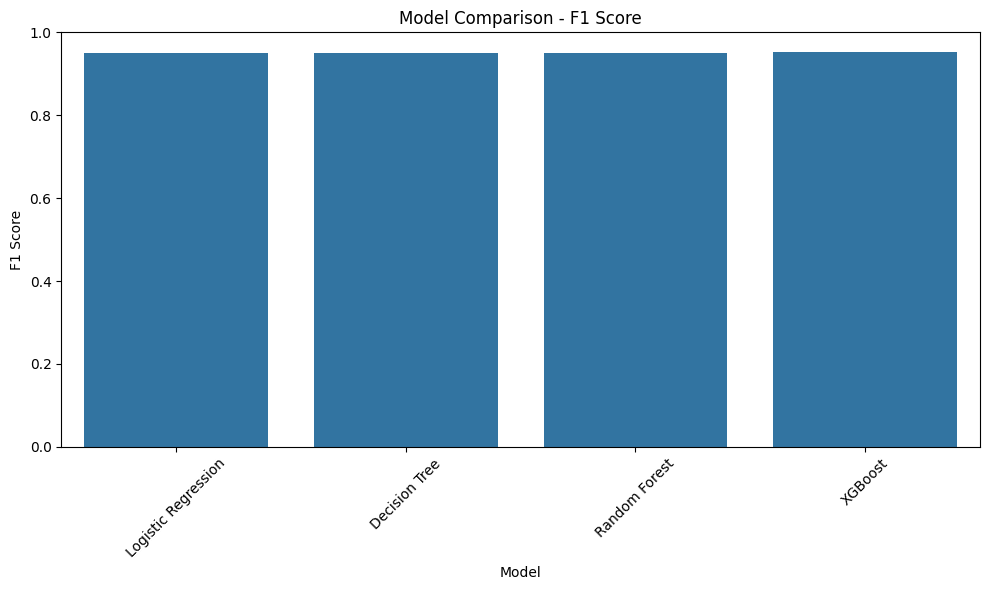

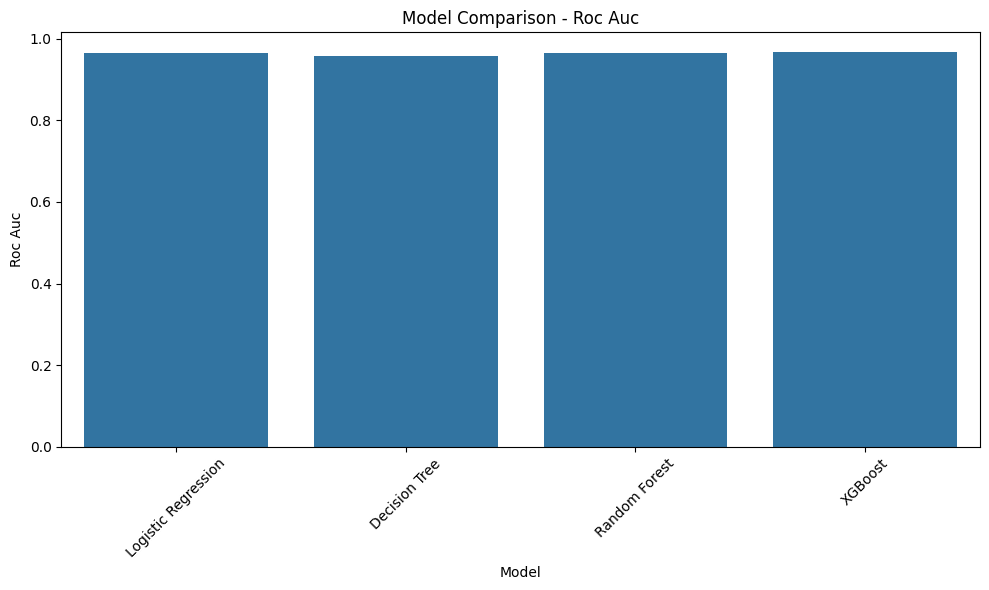


Visualizing confusion matrices...


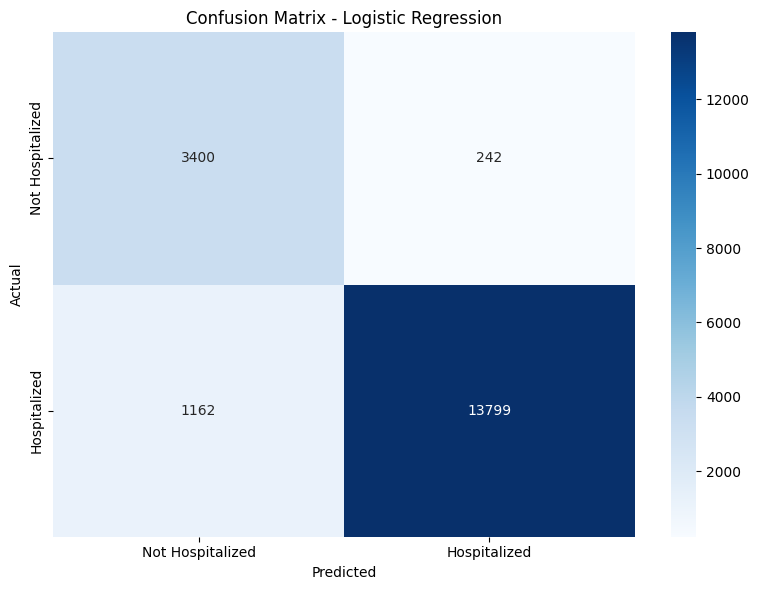

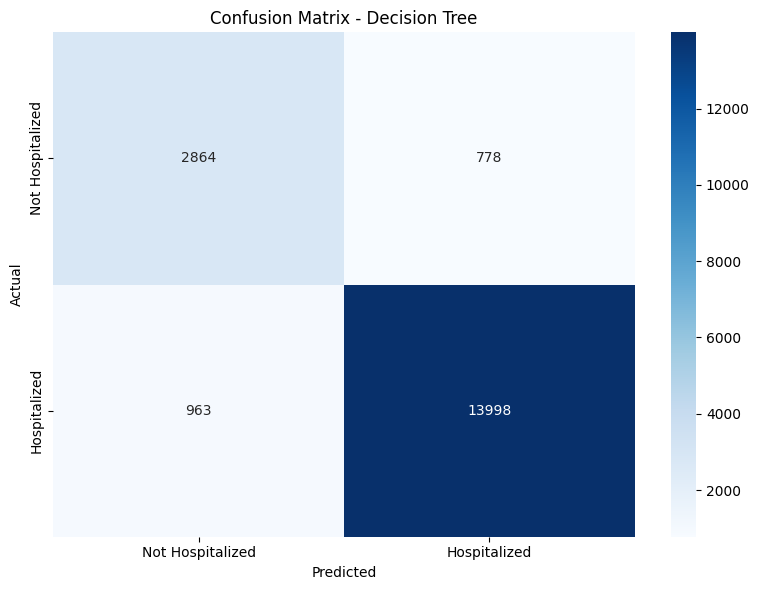

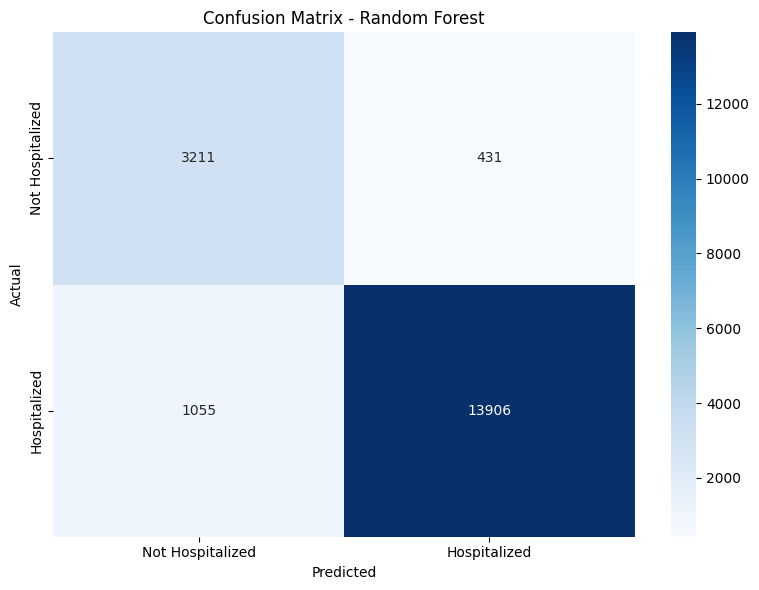

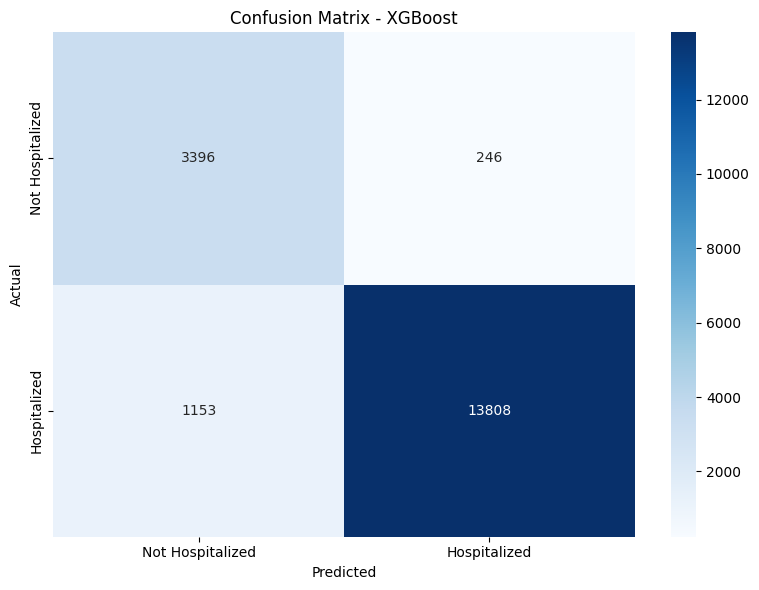


Visualizing ROC curves...


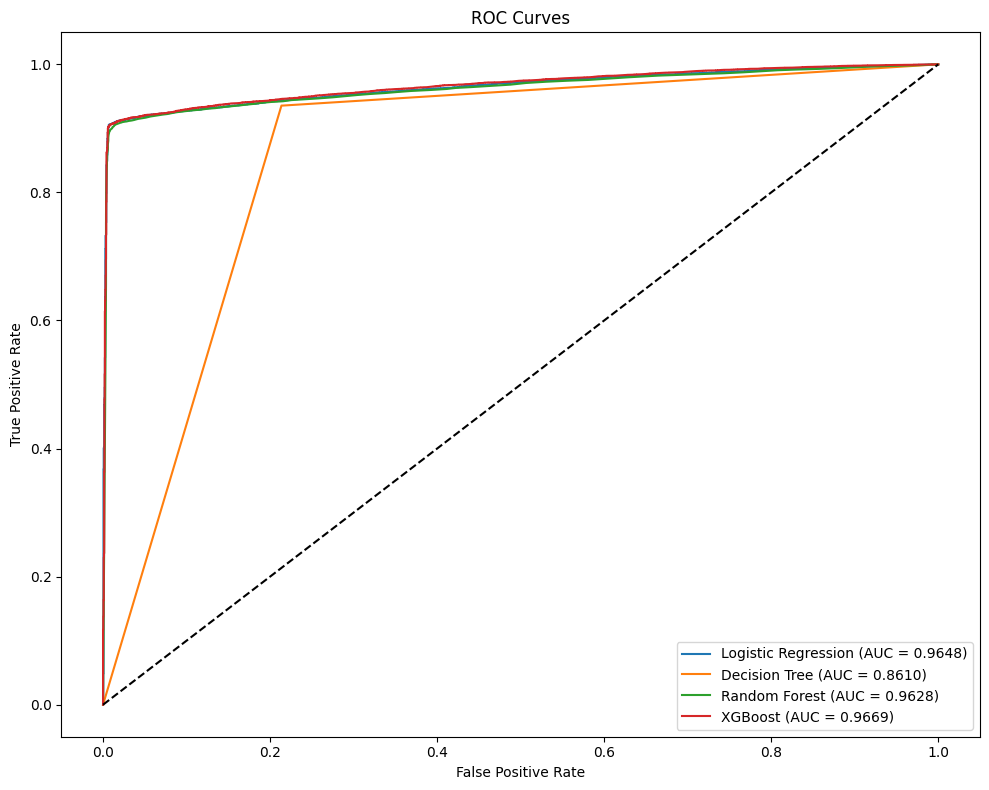


Visualizing confusion matrices...


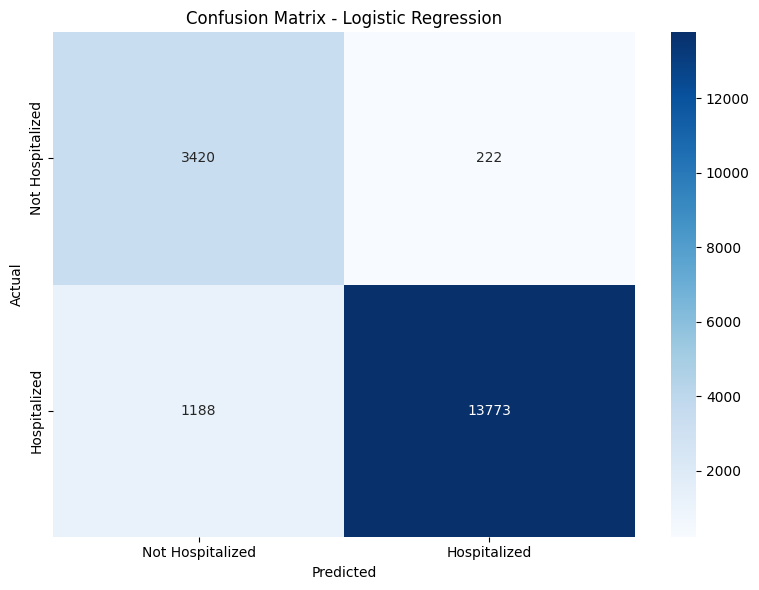

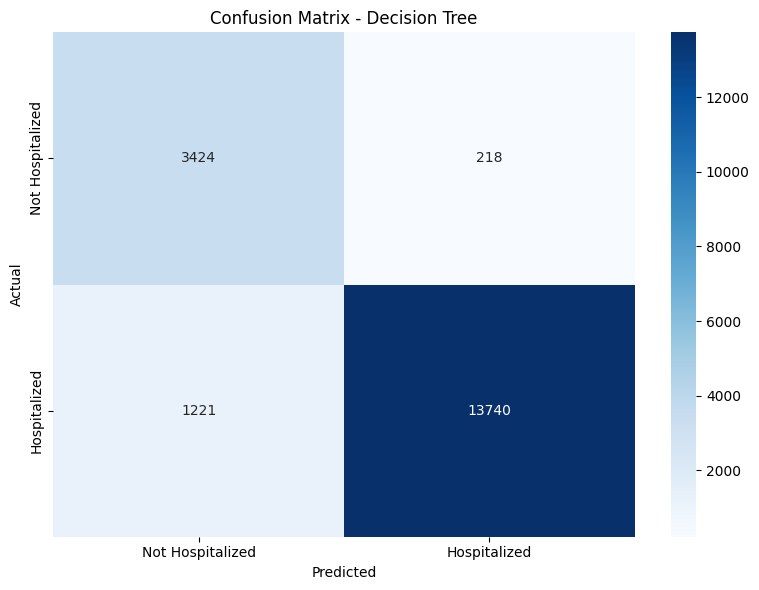

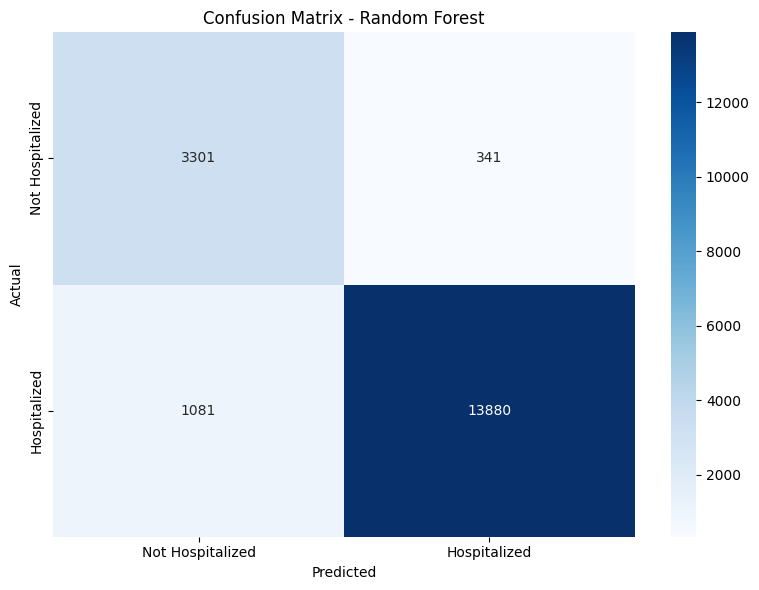

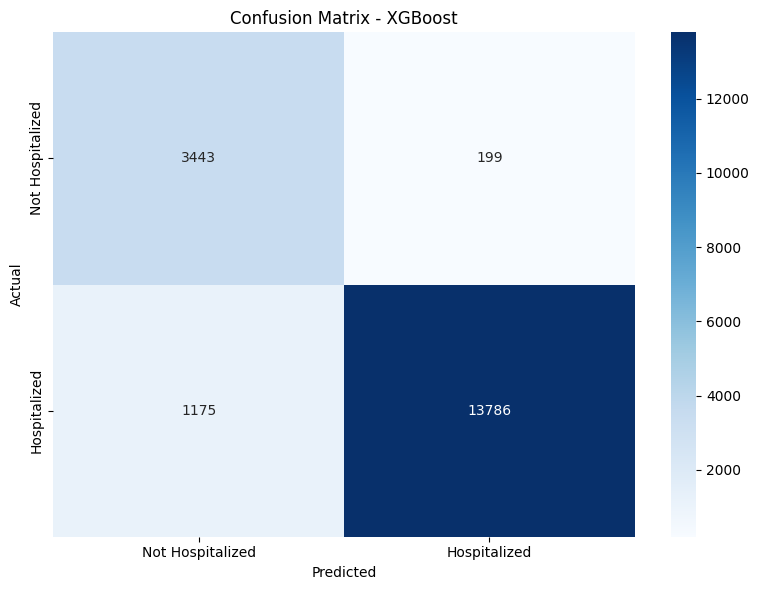


Visualizing ROC curves...


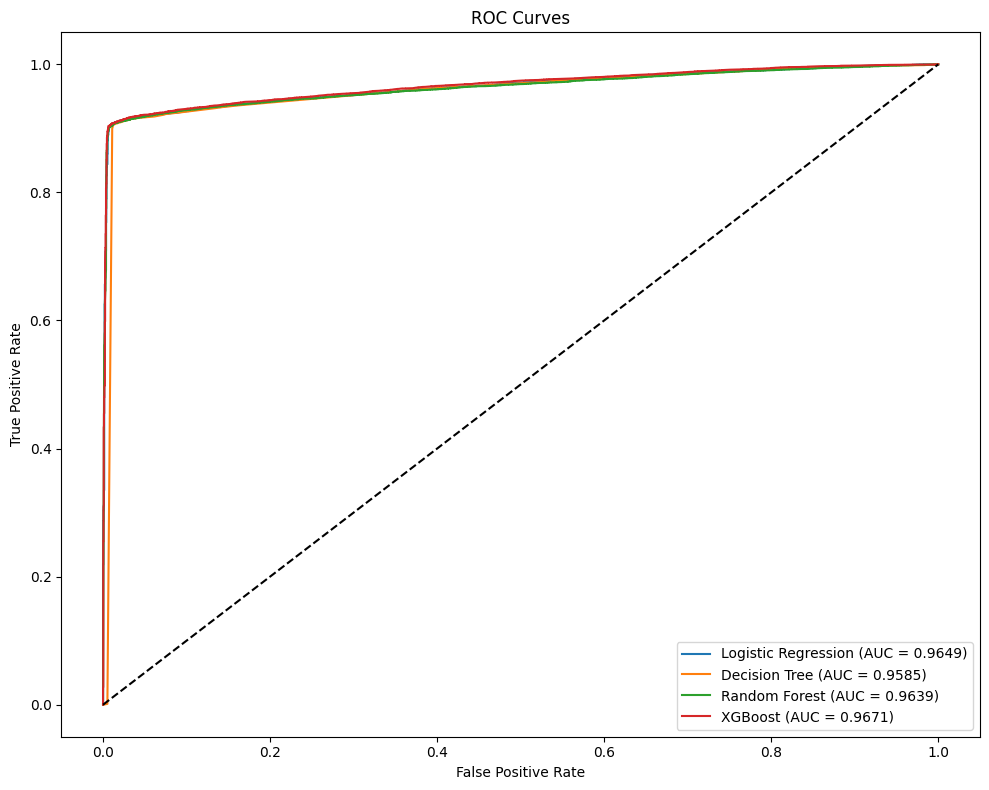

In [41]:
# 1. Visualize feature importances (if available)
if 'feature_importances' in locals() or 'feature_importances' in globals():
    visualize_feature_importance(feature_importances)

# 2. Visualize data insights
visualize_data_insights(data)

# 3. Visualize model comparison (if results are available)
if 'results' in locals() or 'results' in globals():
    visualize_model_comparison(results)

# 4. Visualize model comparison for optimized models (if available)
if 'best_models' in locals() or 'best_models' in globals():
    visualize_model_comparison(best_models)

# For confusion matrices and ROC curves, we need trained models
# If you want to visualize these, you'd need to:
# 1. Make sure 'results' and/or 'best_models' contain trained model objects
# 2. Run the following:

# For initial models (if available with model objects)
if 'results' in locals() or 'results' in globals():
    if 'model' in results[list(results.keys())[0]]:  # Check if model objects exist
        visualize_confusion_matrices(results, X_test, y_test)
        visualize_roc_curves(results, X_test, y_test)

# For optimized models (if available with model objects)
if 'best_models' in locals() or 'best_models' in globals():
    if 'model' in best_models[list(best_models.keys())[0]]:  # Check if model objects exist
        visualize_confusion_matrices(best_models, X_test, y_test)
        visualize_roc_curves(best_models, X_test, y_test)

In [42]:
import pickle
import joblib
import os
from datetime import datetime

In [43]:
def save_model(best_model, model_dir="model"):
    """
    Save the model to disk using both pickle and joblib
    """
    print("\nSaving model to disk...")

    # Create directory if it doesn't exist
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    # Save using pickle
    pickle_path = os.path.join(model_dir, "hospitalization_prediction_model.pkl")
    with open(pickle_path, 'wb') as file:
        pickle.dump(best_model, file)
    print(f"Model saved as pickle to {pickle_path}")

    # Save using joblib (better for large models)
    joblib_path = os.path.join(model_dir, "hospitalization_prediction_model.joblib")
    joblib.dump(best_model, joblib_path)
    print(f"Model saved as joblib to {joblib_path}")

    return pickle_path, joblib_path

In [44]:
def save_feature_info(categorical_features, numerical_features, model_dir="model"):
    """
    Save information about required features
    """
    print("\nSaving feature information...")

    # Ensure directory exists
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    # Save feature names
    feature_path = os.path.join(model_dir, "model_features.txt")
    with open(feature_path, 'w') as file:
        file.write("Categorical features:\n")
        file.write("\n".join(categorical_features))
        file.write("\n\nNumerical features:\n")
        file.write("\n".join(numerical_features))

    print(f"Feature information saved to {feature_path}")
    return feature_path

In [45]:
def create_metadata(best_model, categorical_features, numerical_features, model_dir="model"):
    """
    Create metadata file with model information
    """
    print("\nCreating model metadata...")

    # Ensure directory exists
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    # Create metadata file
    metadata_path = os.path.join(model_dir, "model_metadata.txt")
    with open(metadata_path, 'w') as file:
        file.write(f"Model: Hospitalization Prediction Model (XGBoost)\n")
        file.write(f"Created: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        file.write(f"Number of features: {len(categorical_features) + len(numerical_features)}\n")
        file.write(f"Feature types: {len(categorical_features)} categorical, {len(numerical_features)} numerical\n")

        # Add hyperparameters if available
        if hasattr(best_model, 'get_params'):
            file.write("\nHyperparameters:\n")
            for param, value in best_model.get_params().items():
                if param.startswith('classifier__'):
                    clean_param = param.replace('classifier__', '')
                    file.write(f"- {clean_param}: {value}\n")

    print(f"Model metadata saved to {metadata_path}")
    return metadata_path

In [46]:
def create_prediction_script(model_dir="model"):
    """
    Create a Python script for making predictions
    """
    print("\nCreating prediction script...")

    # Ensure directory exists
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    # Create prediction script
    script_path = os.path.join(model_dir, "predict.py")
    with open(script_path, 'w') as file:
        file.write("""import pandas as pd
import joblib
import pickle

def load_model(model_path="hospitalization_prediction_model.joblib"):
    \"\"\"
    Load the trained model
    \"\"\"
    try:
        # Try joblib first
        model = joblib.load(model_path)
        print(f"Model loaded successfully from {model_path}")
        return model
    except:
        # Fall back to pickle
        model_path = model_path.replace(".joblib", ".pkl")
        with open(model_path, 'rb') as file:
            model = pickle.load(file)
        print(f"Model loaded successfully from {model_path}")
        return model

def predict_hospitalization(model, input_data):
    \"\"\"
    Make predictions using the trained model

    Parameters:
    -----------
    model : trained model
        The trained machine learning model
    input_data : dict or DataFrame
        Input data containing required features

    Returns:
    --------
    prediction : int
        0 = Not Hospitalized, 1 = Hospitalized
    probability : float
        Probability of hospitalization
    \"\"\"
    # Convert input to DataFrame if it's a dictionary
    if isinstance(input_data, dict):
        input_data = pd.DataFrame([input_data])

    # Make prediction
    prediction = model.predict(input_data)[0]

    # Get probability if available
    probability = None
    if hasattr(model, 'predict_proba'):
        probability = model.predict_proba(input_data)[0, 1]

    return prediction, probability

def example_usage():
    \"\"\"
    Example of how to use the prediction function
    \"\"\"
    # Load model
    model = load_model("hospitalization_prediction_model.joblib")

    # Example input (replace with actual required features)
    example_input = {
        'State': 'TEXAS',
        'Nature': '1311',
        'Part of Body': '4422',
        'Event': '6412',
        'Source': '6629',
        'Secondary Source': '5772.0',
        'Latitude': 41.46,
        'Longitude': -74.53
    }

    # Make prediction
    prediction, probability = predict_hospitalization(model, example_input)

    # Print results
    print(f"Prediction: {'Hospitalized' if prediction == 1 else 'Not Hospitalized'}")
    if probability is not None:
        print(f"Probability of hospitalization: {probability:.2f}")

if __name__ == "__main__":
    example_usage()
""")

    print(f"Prediction script saved to {script_path}")
    return script_path

In [47]:
def create_api_script(model_dir="model"):
    """
    Create a Flask API for model deployment
    """
    print("\nCreating Flask API script...")

    # Ensure directory exists
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    # Create API script
    api_path = os.path.join(model_dir, "api.py")
    with open(api_path, 'w') as file:
        file.write("""from flask import Flask, request, jsonify
import pandas as pd
import joblib
import os

# Create Flask app
app = Flask(__name__)

# Load model
MODEL_PATH = "hospitalization_prediction_model.joblib"
model = None

def load_model():
    global model
    model = joblib.load(MODEL_PATH)
    print(f"Model loaded successfully from {MODEL_PATH}")

@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Get JSON data from request
        data = request.json

        # Convert to DataFrame
        input_data = pd.DataFrame([data])

        # Make prediction
        prediction = int(model.predict(input_data)[0])

        # Get probability if available
        probability = None
        if hasattr(model, 'predict_proba'):
            probability = float(model.predict_proba(input_data)[0, 1])

        # Return prediction
        result = {
            'prediction': 'Hospitalized' if prediction == 1 else 'Not Hospitalized',
            'prediction_code': prediction
        }

        if probability is not None:
            result['probability'] = probability

        return jsonify(result)

    except Exception as e:
        return jsonify({'error': str(e)}), 400

if __name__ == '__main__':
    # Load model when the app starts
    load_model()

    # Run API
    app.run(debug=True, host='0.0.0.0', port=5000)
""")

    print(f"Flask API script saved to {api_path}")
    return api_path

In [48]:
def create_requirements_file(model_dir="model"):
    """
    Create requirements.txt file for deployment
    """
    print("\nCreating requirements file...")

    # Ensure directory exists
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    # Create requirements file
    req_path = os.path.join(model_dir, "requirements.txt")
    with open(req_path, 'w') as file:
        file.write("""# Core libraries
numpy>=1.20.0
pandas>=1.3.0
scikit-learn>=1.0.0
joblib>=1.1.0

# XGBoost
xgboost>=1.5.0

# API deployment
flask>=2.0.0
gunicorn>=20.1.0

# Visualization (optional for deployment)
matplotlib>=3.5.0
seaborn>=0.11.0
""")

    print(f"Requirements file saved to {req_path}")
    return req_path

In [49]:
def create_readme(model_dir="model"):
    """
    Create README file with deployment instructions
    """
    print("\nCreating README...")

    # Ensure directory exists
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    # Create README
    readme_path = os.path.join(model_dir, "README.md")
    with open(readme_path, 'w') as file:
        file.write("""# OSHA Hospitalization Prediction Model

## Overview
This model predicts whether a workplace incident will result in hospitalization based on various features such as the nature of injury, body part affected, and geographic location.

## Files
- `hospitalization_prediction_model.joblib`: Main model file (joblib format)
- `hospitalization_prediction_model.pkl`: Backup model file (pickle format)
- `model_features.txt`: List of features used by the model
- `model_metadata.txt`: Information about the model and its parameters
- `predict.py`: Script with functions to load the model and make predictions
- `api.py`: Flask API for serving predictions
- `requirements.txt`: Required packages for deployment

## Usage
1. Load the model using the `load_model()` function in `predict.py`
2. Prepare your input data with all required features
3. Use the `predict_hospitalization()` function to get predictions
4. See `example_usage()` in `predict.py` for a complete example

## API Deployment
1. Install required packages: `pip install -r requirements.txt`
2. Run the API server: `python api.py`
3. Send POST requests to `http://localhost:5000/predict` with JSON input data

## Required Features
The model requires specific categorical and numerical features. See `model_features.txt` for the complete list.

## Maintenance
For best results, the model should be retrained periodically as new data becomes available.
""")

    print(f"README saved to {readme_path}")
    return readme_path

In [50]:
def deploy_best_model(best_model, categorical_features, numerical_features, model_dir="model"):
    """
    Deploy the best model with all supporting files
    """
    print("\nDeploying best model...")

    # Save model
    pickle_path, joblib_path = save_model(best_model, model_dir)

    # Save feature information
    feature_path = save_feature_info(categorical_features, numerical_features, model_dir)

    # Create metadata
    metadata_path = create_metadata(best_model, categorical_features, numerical_features, model_dir)

    # Create prediction script
    prediction_script = create_prediction_script(model_dir)

    # Create API script
    api_script = create_api_script(model_dir)

    # Create requirements file
    requirements = create_requirements_file(model_dir)

    # Create README
    readme = create_readme(model_dir)

    print("\nModel deployment complete!")
    print("Deployment files created:")
    print(f"  - Model: {pickle_path} and {joblib_path}")
    print(f"  - Feature info: {feature_path}")
    print(f"  - Metadata: {metadata_path}")
    print(f"  - Prediction script: {prediction_script}")
    print(f"  - API: {api_script}")
    print(f"  - Requirements: {requirements}")
    print(f"  - README: {readme}")

    print("\nTo deploy as API:")
    print(f"1. cd {model_dir}")
    print("2. pip install -r requirements.txt")
    print("3. python api.py")
    print("4. Send POST requests to http://localhost:5000/predict")

    return {
        "model_dir": model_dir,
        "model_path": joblib_path,
        "api_path": api_script
    }

# Get the best model
if 'best_models' in locals() or 'best_models' in globals():
    if 'XGBoost' in best_models:
        best_model = best_models['XGBoost']['model']
    else:
        best_model_name = max(best_models.items(), key=lambda x: x[1]['f1_score'])[0]
        best_model = best_models[best_model_name]['model']

    # Deploy the model
    deployment_info = deploy_best_model(best_model, cat_features, num_features)
else:
    print("No optimized models found. Please run model optimization first.")


Deploying best model...

Saving model to disk...
Model saved as pickle to model/hospitalization_prediction_model.pkl
Model saved as joblib to model/hospitalization_prediction_model.joblib

Saving feature information...
Feature information saved to model/model_features.txt

Creating model metadata...
Model metadata saved to model/model_metadata.txt

Creating prediction script...
Prediction script saved to model/predict.py

Creating Flask API script...
Flask API script saved to model/api.py

Creating requirements file...
Requirements file saved to model/requirements.txt

Creating README...
README saved to model/README.md

Model deployment complete!
Deployment files created:
  - Model: model/hospitalization_prediction_model.pkl and model/hospitalization_prediction_model.joblib
  - Feature info: model/model_features.txt
  - Metadata: model/model_metadata.txt
  - Prediction script: model/predict.py
  - API: model/api.py
  - Requirements: model/requirements.txt
  - README: model/README.md



In [51]:
def test_deployed_model(model_dir="model"):
    """
    Test the deployed model using the predict.py script
    """
    print("\nTesting deployed model...")

    import sys
    import os

    # Add model directory to path
    sys.path.append(os.path.abspath(model_dir))

    # Import prediction functions
    from predict import load_model, predict_hospitalization

    # Load model
    model = load_model(os.path.join(model_dir, "hospitalization_prediction_model.joblib"))

    # Create test data
    test_input = {
        'State': 'TEXAS',
        'Nature': '1311',
        'Part of Body': '4422',
        'Event': '6412',
        'Source': '6629',
        'Secondary Source': '5772.0',
        'Latitude': 41.46,
        'Longitude': -74.53
    }

    # Make prediction
    prediction, probability = predict_hospitalization(model, test_input)

    # Print results
    print("\nTest Prediction Results:")
    print(f"Prediction: {'Hospitalized' if prediction == 1 else 'Not Hospitalized'}")
    if probability is not None:
        print(f"Probability of hospitalization: {probability:.4f}")

    print("\nDeployment test successful!")

    return {
        "prediction": prediction,
        "probability": probability
    }

# Test the deployed model
if os.path.exists("model"):
    test_results = test_deployed_model()
else:
    print("Model has not been deployed yet. Please run the deployment cell first.")


Testing deployed model...
Model loaded successfully from model/hospitalization_prediction_model.joblib

Test Prediction Results:
Prediction: Hospitalized
Probability of hospitalization: 0.9973

Deployment test successful!
